In [241]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score,roc_curve, auc,accuracy_score,f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import re

In [242]:
df_tweets = pd.read_csv("../Data/cleaned_tweets.csv")
df_tweets = df_tweets[["tweet","sentiment"]]

# define a function to add label
def row_label(row):
    return 1 if row["sentiment"]=="Positive" else 0

# def remove_brakets(row):
#     return row["tweet"].replace(']','').replace
def remove_brakets(row):
    string= re.sub('\[|\]|\'|\.|"|,', '', row["tweet"])
    #string = string.replace(",","")
    return string

df_tweets["label"] = df_tweets.apply(row_label, axis=1)
# df_tweets["tweet"] = df_tweets.apply(remove_brakets, axis=1)
df_tweets.drop("sentiment",axis=1, inplace=True)

df_tweets.drop_duplicates()
#reduce the data
#Test Data
df_tweets_inp = df_tweets.sample(frac=0.95, random_state=42)
df_test = df_tweets.drop(df_tweets_inp.index)
#df_test = df_test.sample(frac=0.1, random_state=42)

#seperate labelled and unlabelled data
df_labeled_data = df_tweets_inp.sample(frac=0.20, random_state=123)
df_unlabeled_data = df_tweets_inp.drop(df_labeled_data.index)
df_x1_labeled = df_labeled_data.sample(frac=0.10, random_state=42)
df_x2_labeled = df_labeled_data.drop(df_x1_labeled.index)
#df_unlabeled_data.drop("label",axis=1, inplace=True)
#print(df_test[df_test["label"]==1].count,df_test[df_test["label"]==0].count)
#print(df_labeled_data[df_labeled_data["label"]==1].count,df_labeled_data[df_labeled_data["label"]==0].count)

df_tweets.head(10)

,tweet,label
0,"['im', 'get', 'borderland', 'murder']",1
1,"['come', 'border', 'kill']",1
2,"['im', 'get', 'borderland', 'kill']",1
3,"['im', 'come', 'borderland', 'murder']",1
4,"['im', 'get', 'borderland', '2', 'murder']",1
5,"['im', 'get', 'borderland', 'murder']",1
6,"['spent', 'hour', 'make', 'someth', 'fun', '. ...",1
7,"['spent', 'coupl', 'hour', 'someth', 'fun', 'k...",1
8,"['spent', 'hour', 'someth', 'fun', 'know', ""i'...",1
9,"['spent', 'hour', 'make', 'someth', 'fun', '. ...",1


In [243]:
# convert text data into numerical feature vectors using TF-IDF vectorization
vectorizer = TfidfVectorizer()
labeled_features = vectorizer.fit_transform(df_tweets_inp['tweet'])
labeled_features1 = vectorizer.transform(df_x1_labeled['tweet'])
labeled_features2 = vectorizer.transform(df_x2_labeled['tweet'])
test_features = vectorizer.transform(df_test['tweet'])

# for clf2

# labeled_features2 = vectorizer.fit_transform(df_x2_labeled['tweet'])

# test_features2 = vectorizer.transform(df_test['tweet'])
# vectorizer = CountVectorizer(stop_words='english')
# labeled_features2 = pad_sequences(vectorizer.fit_transform(df_x2_labeled['tweet']).toarray(), maxlen=250)
# test_features2 = pad_sequences(vectorizer.fit_transform(df_test['tweet']).toarray(), maxlen=250)

# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(df_x2_labeled.tweet.values)
# sequences = tokenizer.texts_to_sequences(df_x2_labeled.tweet.values)
# labeled_features2 = pad_sequences(labeled_features1)

# tokenizer.fit_on_texts(df_test.tweet.values)
# sequences = tokenizer.texts_to_sequences(df_test.tweet.values)

# test_features2 = pad_sequences(sequences)
# print(data)
# labeled_features2 = vectorizer.fit_transform(df_x2_labeled['tweet'])
# labeled_features2 = pad_sequences(labeled_features2)
# test_features2 = pad_sequences(test_features1)



In [244]:
# train a logistic regression model on the labeled data
# model = LogisticRegression()
# model = MultinomialNB()


model1 = LogisticRegression()
model1.fit(labeled_features1, df_x1_labeled['label'])

#model 2 is Naivebayes


model2 = MultinomialNB()
model2.fit(labeled_features2, df_x2_labeled['label'])

# evaluate the performance of the models on the test data
accuracy1 = model1.score(test_features, df_test['label'])
print("Accuracy Logistic Regression model:", accuracy1)


accuracy2 = model2.score(test_features, df_test['label'])
print("Accuracy Naive bayes Regression model:", accuracy2)


Accuracy Logistic Regression model: 0.7638307763830776
Accuracy Naive bayes Regression model: 0.8396094839609484


In [245]:
def splitData(dataframe,noofdivision):
    # list = []
    # totaldfsize = dataframe.shape[0]
    # for i in range(1,noofdivision+1):
    dataframe = dataframe.sample(frac=1)
    lst_dfs = np.array_split(dataframe,noofdivision)
    return lst_dfs
# totaldfsize = df_unlabeled_data.shape[0]
# print(totaldfsize)
# lst_dfs = splitData(df_unlabeled_data,5)
# len(lst_dfs)

def coTrain(model1,model2,df_x1_labeled,df_x2_labeled,lst_dfs,ini_acc1,ini_acc2):
    threshold_acc1 = ini_acc1
    threshold_acc2 = ini_acc2
    i = 0
    for df in lst_dfs:
       i +=1
       unlabeled_features = vectorizer.transform(df['tweet'])
       #filter most confident points
       probabilities = model2.predict_proba(unlabeled_features)
       confidence = np.max(probabilities, axis=1)
       threshold = np.percentile(confidence, 0.1)
       indices = np.where(confidence >= threshold)[0]
       df_prev_lab1 = df_x1_labeled
       #add the psuedo labels preicted from Model 2
       df_x1_labeled = df_x1_labeled.append(df.iloc[indices])

       probabilities = model1.predict_proba(unlabeled_features)
       confidence = np.max(probabilities, axis=1)
       threshold = np.percentile(confidence, 0.1)
       indices = np.where(confidence >= threshold)[0]      
       df_prev_lab2 = df_x2_labeled
       #add the psuedo labels preicted from Model 1
       df_x2_labeled = df_x2_labeled.append(df.iloc[indices])

       labeled_features1 = vectorizer.transform(df_x1_labeled['tweet']) 
       labeled_features2 = vectorizer.transform(df_x2_labeled['tweet']) 

       model1.fit(labeled_features1, df_x1_labeled['label'])
       acurcy1 = model1.score(test_features, df_test['label'])
       model2.fit(labeled_features2, df_x2_labeled['label'])
       acurcy2 = model2.score(test_features, df_test['label'])
       print("Accuracy Classifier 1",i,acurcy1)
       print("Accuracy Classifier 2",i,acurcy2)
       if(acurcy1 < threshold_acc1):
           df_x1_labeled = df_prev_lab1
       if(acurcy2 < threshold_acc2):
           df_x2_labeled = df_prev_lab2
       threshold_acc1 = acurcy1
       threshold_acc2 = acurcy2
    return model1,model2

lst_dfs = splitData(df_unlabeled_data,5)

model1,model2 = coTrain(model1,model2,df_x1_labeled,df_x2_labeled,lst_dfs,accuracy1,accuracy2)

Accuracy Classifier 1 1 0.8372849837284984
Accuracy Classifier 2 1 0.8572756857275686
Accuracy Classifier 1 2 0.8628544862854486
Accuracy Classifier 2 2 0.8744769874476988
Accuracy Classifier 1 3 0.8688981868898187
Accuracy Classifier 2 3 0.8786610878661087
Accuracy Classifier 1 4 0.8768014876801488
Accuracy Classifier 2 4 0.8870292887029289
Accuracy Classifier 1 5 0.8814504881450488
Accuracy Classifier 2 5 0.891213389121339


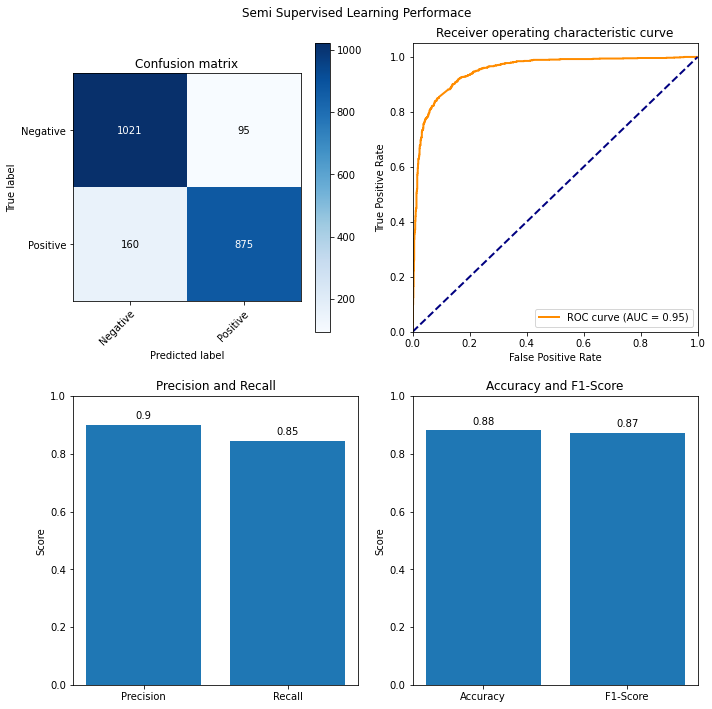

In [246]:
#plots model 1
# assume y_true is the true labels and y_pred is the predicted labels
model = model1
y_true = np.array(df_test['label'])
test_features = vectorizer.transform(df_test['tweet'])
predicted_sentiments = model.predict(test_features)
y_pred = np.array(predicted_sentiments)
y_score = model.predict_proba(test_features)[:, 1]
# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)



# create figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# plot confusion matrix
ax = axs[0,0]
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=["Negative", "Positive"],
       yticklabels=["Negative", "Positive"],
       title="Confusion matrix",
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# plot precision,accuracy, F1 and recall
# calculate precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

ax = axs[1,0]
ax.bar(["Precision", "Recall"], [precision, recall])
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Precision and Recall")
for i, v in enumerate([precision, recall ]):
    ax.text(i, v + 0.02, str(round(v, 2)), ha='center')

#accuracy, F1
ax = axs[1,1]
ax.bar(["Accuracy" , "F1-Score"], [ acc, f1])
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Accuracy and F1-Score")
for i, v in enumerate([acc, f1]):
    ax.text(i, v + 0.02, str(round(v, 2)), ha='center')


#ROC Curve


# calculate false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# plot ROC curve
ax =  axs[0,1]
ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic curve')
ax.legend(loc="lower right")

# remove axis labels for the bottom right subplot
# axs[1, 1].axis('off')

# add a figure title
fig.suptitle('Semi Supervised Learning Performace')

# adjust subplot spacing and layout
fig.tight_layout()

# show the plot
plt.show()



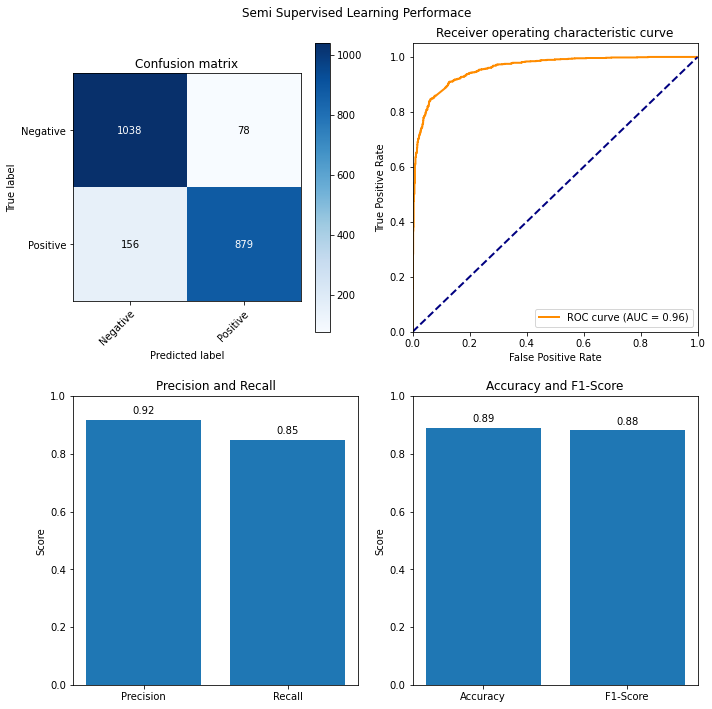

In [247]:
#plots model 2
# assume y_true is the true labels and y_pred is the predicted labels
model = model2
y_true = np.array(df_test['label'])
test_features = vectorizer.transform(df_test['tweet'])
predicted_sentiments = model.predict(test_features)
y_pred = np.array(predicted_sentiments)
y_score = model.predict_proba(test_features)[:, 1]
# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)



# create figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# plot confusion matrix
ax = axs[0,0]
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=["Negative", "Positive"],
       yticklabels=["Negative", "Positive"],
       title="Confusion matrix",
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# plot precision,accuracy, F1 and recall
# calculate precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

ax = axs[1,0]
ax.bar(["Precision", "Recall"], [precision, recall])
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Precision and Recall")
for i, v in enumerate([precision, recall ]):
    ax.text(i, v + 0.02, str(round(v, 2)), ha='center')

#accuracy, F1
ax = axs[1,1]
ax.bar(["Accuracy" , "F1-Score"], [ acc, f1])
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Accuracy and F1-Score")
for i, v in enumerate([acc, f1]):
    ax.text(i, v + 0.02, str(round(v, 2)), ha='center')


#ROC Curve


# calculate false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# plot ROC curve
ax =  axs[0,1]
ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic curve')
ax.legend(loc="lower right")

# remove axis labels for the bottom right subplot
# axs[1, 1].axis('off')

# add a figure title
fig.suptitle('Semi Supervised Learning Performace')

# adjust subplot spacing and layout
fig.tight_layout()

# show the plot
plt.show()

